# Travail pratique 1 - IFT 3700
##### Remis le 22 novembre 2020 par Rym Bach et Laurier Lavoie-Giasson
## Introduction
Dans le cadre de ce travail, on s'intéresse à la précision des différentes techniques de classification vues en classe, et de comparer son niveau en utilisant la distance euclidienne ainsi que [...]
## Code
### Installation des packages nécessaires

In [11]:
import sys
!{sys.executable} -m pip install tqdm

### Chargement et prétraitement des jeux de données d'entraînement et de tests

In [13]:
%matplotlib inline
import csv
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import TruncatedSVD


def preprocessing(X, n_dimensions=784):
    #cette fonction sera utilisée pour le prétraitement des données du jeu de données.
    #X doit être une matrice de taille (n,784)
    
    return np.array([np.round(np.divide(X[i], 255.0)) for i in tqdm(range(len(X))) ])
    
def readMNIST(filename, n_dimensions=784):
    #cette fonction lit le fichier de MNIST à l'emplacement fourni et retourne le jeu de
    #données sur lequel on a appliqué la fonction de prétraitement
    data = open(filename)
    csv_file = csv.reader(data)
    data_points = [row for row in csv_file] #pour enlever les headers
    data_points.pop(0)
    #valeurs Y de taille 1 (labels)
    print("Extraction des labels pour", filename)
    Y = np.array([int(data_points[i][0]) for i in tqdm(range(len(data_points)))])
    
    #vecteurs X de taille 784 (arrondis à l'entier le plus près)
    print("Extraction des points de données pour", filename)
    X = np.array([[int(j) for j in data_points[i][1:]] for i in tqdm(range(len(data_points)))])
    X = X.reshape((len(Y),784))
    
    #on retourne un tuple avec les vecteurs x et les valeurs y
    return (preprocessing(X, n_dimensions),Y)

XY_train = readMNIST('mnist_train.csv')
X_train = XY_train[0]
Y_train = XY_train[1]

XY_test = readMNIST('mnist_test.csv')
X_test = XY_test[0]
Y_test = XY_test[1]

  1%|          | 347/60000 [00:00<00:17, 3458.22it/s]

Extraction des labels pour mnist_train.csv
Extraction des points de données pour mnist_train.csv


  4%|▎         | 353/10000 [00:00<00:02, 3525.44it/s]

Extraction des labels pour mnist_test.csv
Extraction des points de données pour mnist_test.csv


100%|██████████| 10000/10000 [00:00<00:00, 42798.63it/s]


### _Sanity Check_
Ici on regarde si les données sont encore "saines", c'est à dire si on peut afficher la première lettre du jeu de données

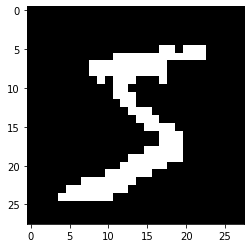

In [14]:
plt.imshow(X_train[0].reshape((28,28)), cmap="gray")
plt.show()

On voit que la lettre apparait bel et bien, on peut donc considérer que le jeu de données a été correctement chargé

### Classification en utilisant l'algorithme K-médoïdes

In [ ]:
#TODO Classification KMeans
#en utilisant plusieurs valeurs de K (8,9,10, 11, ...)
#et en calculant le score silhouette à chaque valeur de K

### Classification en utilisant l'algorithme des K plus proches voisins

In [ ]:
#TODO Classification K-Nearest-Neighbors
#en utilisant plusieurs valeurs de K
def classifyKNN(aX_train, aY_train, aX_test, aY_train, max_neighbors)
    accuracy=[]
    
    for i in tqdm(range(max_neighbors)):
        classifier = KNeighborsClassifier(n_neighbors=(i+1))
        classifier.fit(aX_train, aY_train)
        accuracy.append((i,classifier.score(aX_test, aY_test)))
    return accuracy

for myTuple in classifyKNN:
    print(myTuple)